# **Wasserstein Kmean en une dimension**

In [142]:
# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans
#from ot import emd2  # Pour le calcul de la distance de Wasserstein
import yfinance as yf

In [143]:
def preprocess_data(raw_data, window=30, step=1):
    """
    Prétraite les données brutes pour les rendre utilisables par l'algorithme.
    :param raw_data: Série de prix brute (réelle ou synthétique)
    :param window: Taille des fenêtres glissantes (H1)
    :param step: Pas entre fenêtres glissantes (H2)
    :return: Rendements moyens sur des fenêtres
    """
    # Calcul des log-rendements instantanés
    log_returns = np.diff(np.log(raw_data))

    # Calcul des log-rendements moyens avec fenêtre glissante
    windowed_log_returns = np.array([
        np.mean(log_returns[i:i + window]) for i in range(0, len(log_returns) - window + 1, step)
    ])

    return windowed_log_returns

In [144]:
# Classe pour implémenter l'algorithme Wasserstein K-means
class WassersteinKMeans:
    def __init__(self, n_clusters, max_iter=100, tol=1e-4):
        """
        Initialise les paramètres de l'algorithme WK-means.
        :param n_clusters: Nombre de clusters (k)
        :param max_iter: Nombre maximal d'itérations
        :param tol: Tolérance pour la convergence
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None  # Contiendra les barycentres des clusters

    def fit(self, data):
        """
        Applique l'algorithme Wasserstein K-means sur les données.
        :param data: Ensemble des données à regrouper
        :return: Labels des clusters pour chaque point de donnée
        """
        # Initialisation des centroids avec KMeans classique
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        labels = kmeans.fit_predict(data)  # Obtenir les premiers clusters
        # Calcul des barycentres initiaux
        self.centroids = [self.compute_wasserstein_barycenter(data[labels == k]) for k in range(self.n_clusters)]

        for iteration in range(self.max_iter):
            # Mettre à jour les barycentres pour chaque cluster
            new_centroids = []
            for k in range(self.n_clusters):
                # Points appartenant au cluster k
                cluster_points = data[labels == k]
                if len(cluster_points) > 0:
                    # Calcul du barycentre Wasserstein pour le cluster
                    centroid = self.compute_wasserstein_barycenter(cluster_points)
                    new_centroids.append(centroid)
                else:
                    # Si le cluster est vide, garder l'ancien centroid
                    new_centroids.append(self.centroids[k])

            # Convergence : Calcul du déplacement des barycentres
            shift = np.sum([wasserstein_distance(self.centroids[i], new_centroids[i]) for i in range(self.n_clusters)])
            if shift < self.tol:  # Critère de tolérance
                break

            # Mise à jour des centroids
            self.centroids = new_centroids

            # Réassignation des labels en fonction des nouvelles distances Wasserstein
            labels = np.array([
                np.argmin([wasserstein_distance(data[i], self.centroids[j]) for j in range(self.n_clusters)])
                for i in range(len(data))
            ])

        return labels

    def compute_wasserstein_barycenter(self, distributions):
        """
        Calcul d'un barycentre Wasserstein approximé comme moyenne arithmétique.
        :param distributions: Points dans le cluster
        :return: Barycentre Wasserstein approximé
        """
        return np.mean(distributions, axis=0)  # Moyenne arithmétique comme approximation


In [145]:
# Récupérer les données de Yahoo Finance sur une semaine avec un timeframe de 1 minute
def get_yahoo_data(symbol, period="1d", interval="1m"):
    """
    Récupère les données boursières de Yahoo Finance pour un symbole donné.
    :param symbol: Le symbole de l'action ou de la paire de devises
    :param period: Période de données à récupérer ('1wk' pour une semaine)
    :param interval: Intervalle de temps entre les points de données ('1m' pour une minute)
    :return: Données récupérées sous forme de DataFrame
    """
    data = yf.download(symbol, period=period, interval=interval)
    return data

**Test sur data générée simplement**




In [146]:
# Exemple 1 : Générer des données synthétiques
def generate_synthetic_data(length=1000):
    """
    Génère des séries de prix synthétiques pour simuler des données Forex.
    :param length: Longueur de la série
    :return: Série de prix synthétique
    """
    return np.random.normal(1, 0.05, length).cumprod()

# Exemple 2 : Charger des données réelles
# raw_data = pd.read_csv("forex_data.csv")["close_prices"].values  # Exemple avec pandas

# Pour cet exemple, on utilisera des données synthétiques
raw_data = generate_synthetic_data()


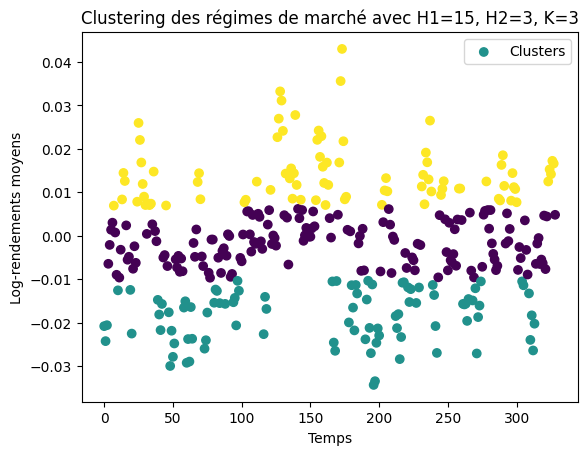

In [147]:
# Hyperparamètres
H1 = 15  # Taille des fenêtres
H2 = 3   # Pas entre fenêtres
K = 3   # Nombre de clusters

# Prétraitement des données
processed_data = preprocess_data(raw_data, window=H1, step=H2)

# Appliquer l'algorithme Wasserstein K-means
wasserstein_kmeans = WassersteinKMeans(n_clusters=K)
labels = wasserstein_kmeans.fit(processed_data.reshape(-1, 1))

# Visualisation des résultats
plt.scatter(range(len(processed_data)), processed_data, c=labels, cmap='viridis', label="Clusters")
plt.xlabel("Temps")
plt.ylabel("Log-rendements moyens")
plt.title(f"Clustering des régimes de marché avec H1={H1}, H2={H2}, K={K}")
plt.legend()
plt.show()


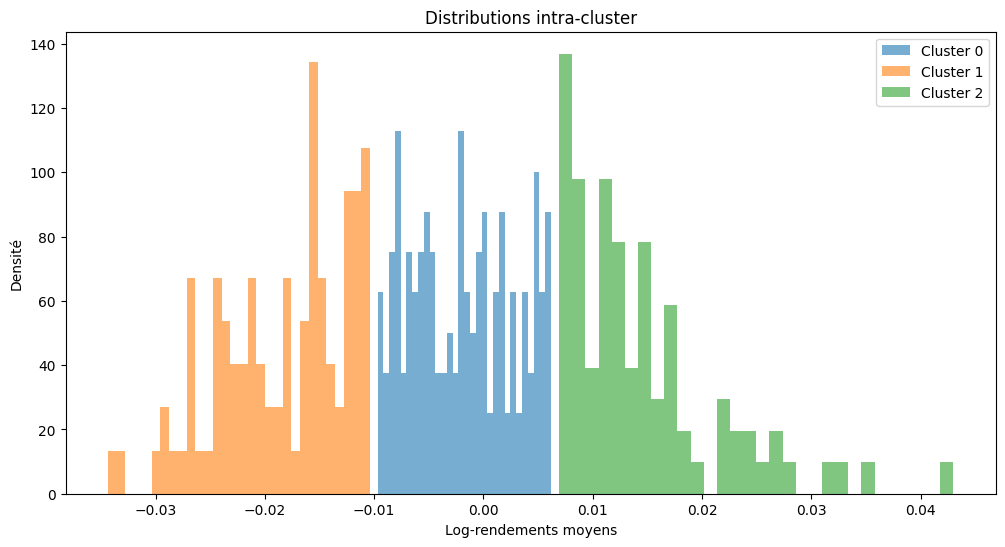

In [148]:
plt.figure(figsize=(12, 6))
for k in range(K):
    cluster_points = processed_data[labels == k]
    plt.hist(cluster_points, bins=30, alpha=0.6, label=f"Cluster {k}", density=True)
plt.xlabel("Log-rendements moyens")
plt.ylabel("Densité")
plt.title("Distributions intra-cluster")
plt.legend()
plt.show()


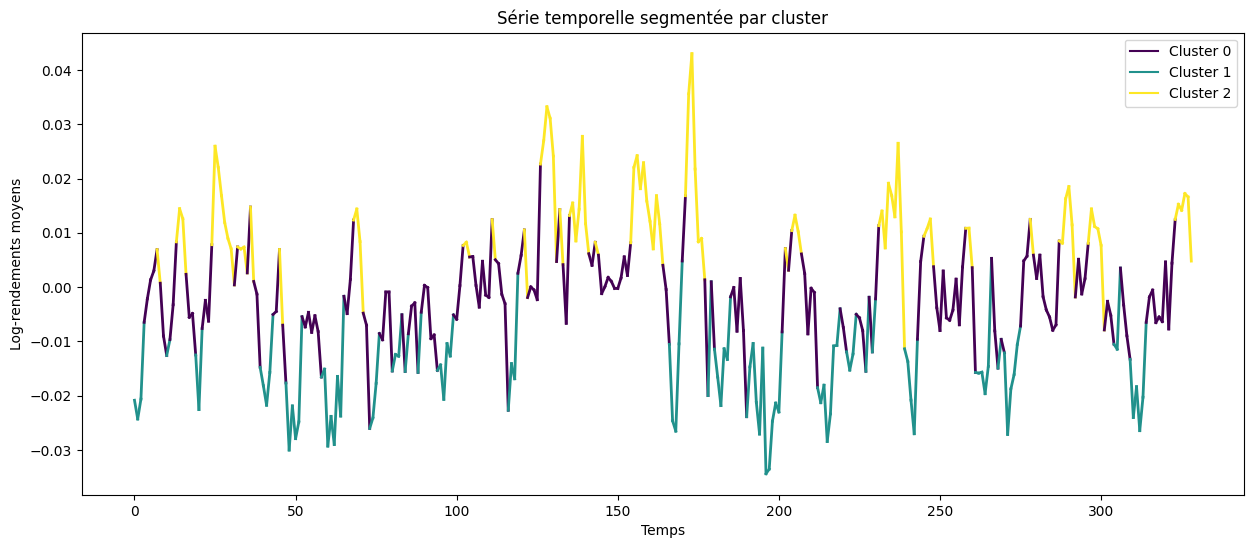

In [149]:
plt.figure(figsize=(15, 6))
colors = plt.cm.viridis(np.linspace(0, 1, K))  # Générer des couleurs distinctes
for i in range(len(processed_data) - 1):
    plt.plot(
        [i, i + 1],
        [processed_data[i], processed_data[i + 1]],
        color=colors[labels[i]],
        linewidth=2
    )
plt.xlabel("Temps")
plt.ylabel("Log-rendements moyens")
plt.title("Série temporelle segmentée par cluster")
for k in range(K):
    plt.plot([], [], color=colors[k], label=f"Cluster {k}")  # Légende des clusters
plt.legend()
plt.show()


<ipython-input-150-0a33ce374c1f>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_per_cluster, labels=[f"Cluster {k}" for k in range(K)])


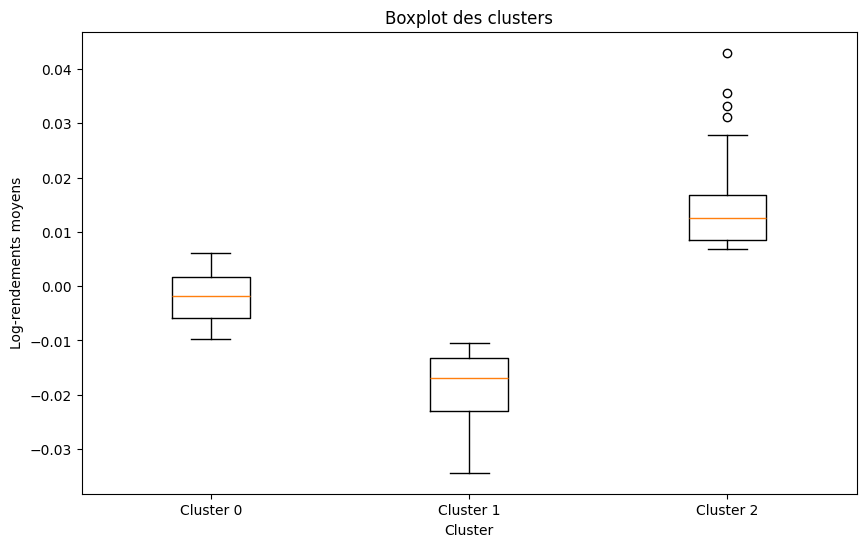

In [150]:
plt.figure(figsize=(10, 6))
data_per_cluster = [processed_data[labels == k] for k in range(K)]
plt.boxplot(data_per_cluster, labels=[f"Cluster {k}" for k in range(K)])
plt.xlabel("Cluster")
plt.ylabel("Log-rendements moyens")
plt.title("Boxplot des clusters")
plt.show()


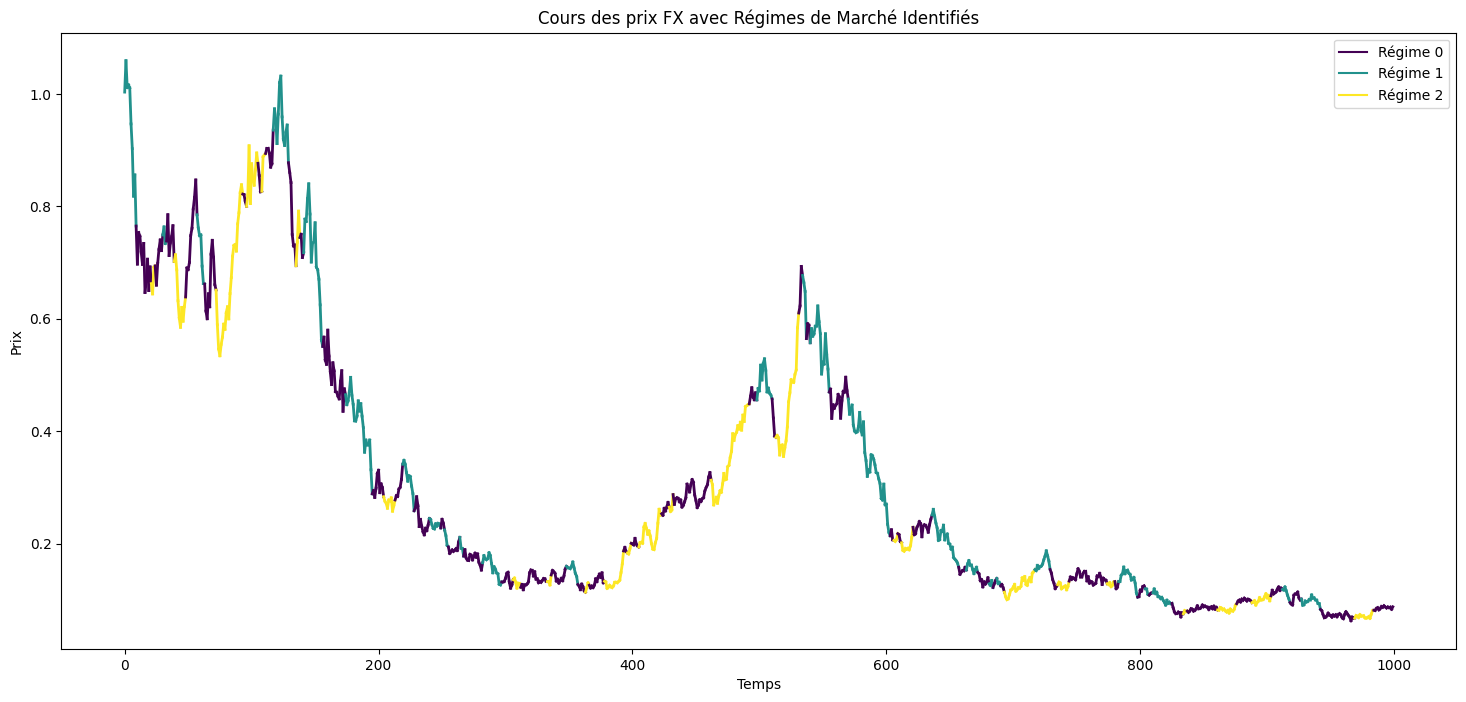

In [151]:
colors = plt.cm.viridis(np.linspace(0, 1, K))

for i in range(len(raw_data) - 1):
    plt.plot([i, i + 1], [raw_data[i], raw_data[i + 1]], color=colors[labels[min(i // H2, len(labels)-1)]], linewidth=2)

plt.xlabel("Temps")
plt.ylabel("Prix")
plt.title("Cours des prix FX avec Régimes de Marché Identifiés")
for i in range(K):
    plt.plot([], [], color=colors[i], label=f"Régime {i}")
plt.legend()
plt.gcf().set_size_inches(18, 8)
plt.show()


Yhaoo finance

[*********************100%***********************]  1 of 1 completed


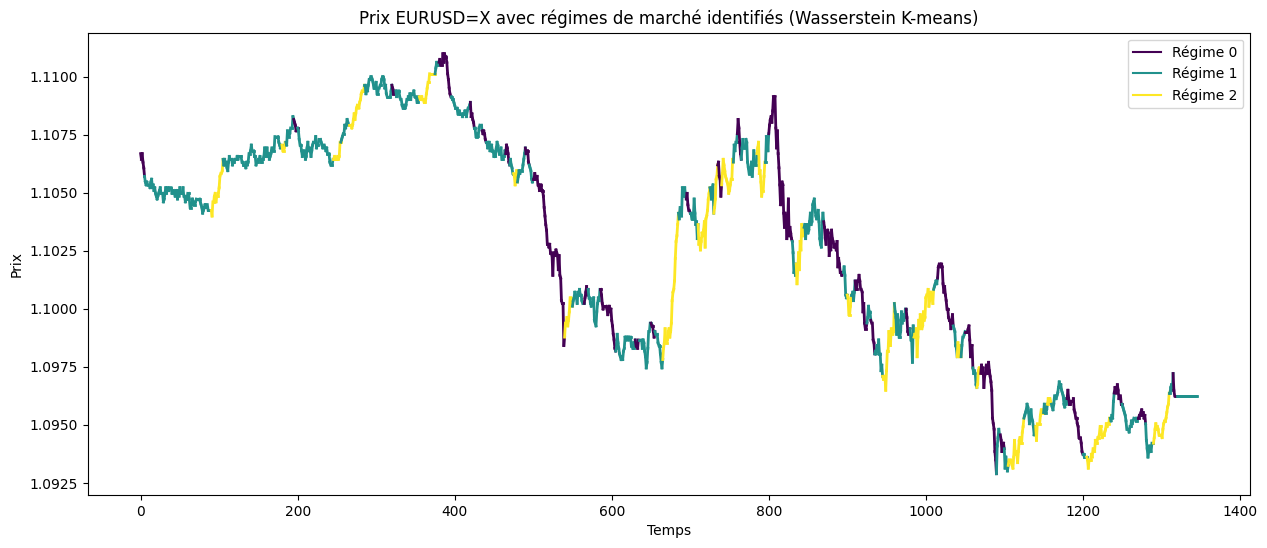

In [152]:
# Récupérer les données de Yahoo Finance
symbol = "EURUSD=X"
data = get_yahoo_data(symbol)

# Si close_prices est 2D, on l'aplatit (avant de le passer à preprocess_data)
close_prices = data['Close'].values.flatten()  # Aplatir ici, pas dans preprocess_data

# Prétraiter les données (par exemple, créer des fenêtres de taille H1)
H1 = 15 # Taille des fenêtres
H2 = 5   # Pas entre fenêtres

# Passer directement close_prices (déjà aplati) à preprocess_data
processed_data = preprocess_data(close_prices, window=H1, step=H2)

# Appliquer l'algorithme Wasserstein K-means
K = 3  # Nombre de clusters
wasserstein_kmeans = WassersteinKMeans(n_clusters=K)
labels = wasserstein_kmeans.fit(processed_data.reshape(-1, 1))

# Visualiser les résultats
colors = plt.cm.viridis(np.linspace(0, 1, K))

plt.figure(figsize=(15, 6))
for i in range(len(close_prices) - 1):
    plt.plot([i, i + 1], [close_prices[i], close_prices[i + 1]], color=colors[labels[min(i // H2, len(labels)-1)]], linewidth=2)

plt.xlabel("Temps")
plt.ylabel("Prix")
plt.title(f"Prix {symbol} avec régimes de marché identifiés (Wasserstein K-means)")
for i in range(K):
    plt.plot([], [], color=colors[i], label=f"Régime {i}")
plt.legend()
plt.show()


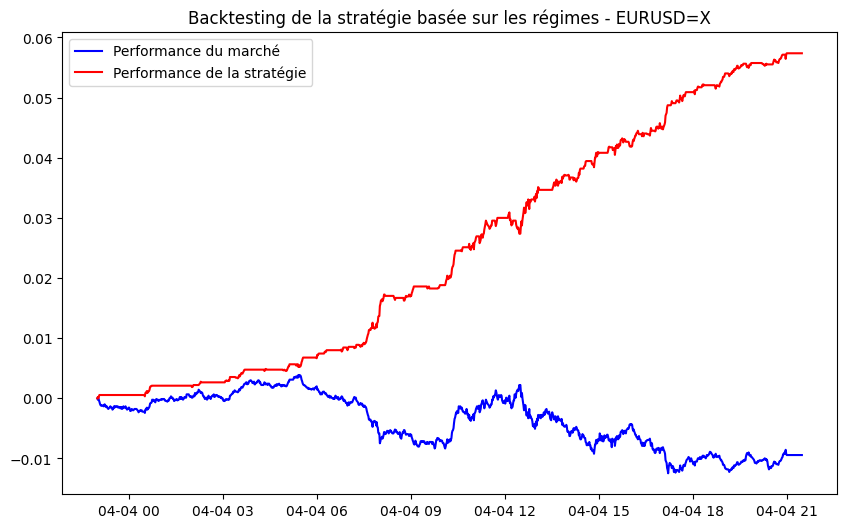

In [153]:
# Stratégie basée sur les régimes de marché identifiés
# Initialiser tous les signaux à 0
signals = np.zeros(len(close_prices))

# Indices dans le temps où les détections de régimes ont eu lieu
detection_times = np.arange(0, len(labels) * H2, H2)

# On parcourt chaque détection de régime
for i in range(len(labels)):
    start = detection_times[i]
    end = detection_times[i+1] if i+1 < len(detection_times) else len(close_prices)

    regime = labels[i]

    if regime == 0:
        signals[start:end] = -1 # Vendre
    elif regime == 2:
        signals[start:end] = 1   # Acheter
    else:
        signals[start:end] = 0  # Ne rien faire



# Créer les rendements de la stratégie
returns = data['Close'].pct_change()
returns = returns.fillna(0)
strategy_returns = returns['EURUSD=X'].values * signals  # Appliquer les signaux de trading

# Calculer la performance cumulée
data['Cumulative_Returns'] = (1 + returns).cumprod() - 1
data['Cumulative_Strategy_Returns'] = (1 + strategy_returns).cumprod() - 1

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(data['Cumulative_Returns'], label='Performance du marché', color='blue')
plt.plot(data['Cumulative_Strategy_Returns'], label='Performance de la stratégie', color='red')
plt.title(f"Backtesting de la stratégie basée sur les régimes - {symbol}")
plt.legend()
plt.show()


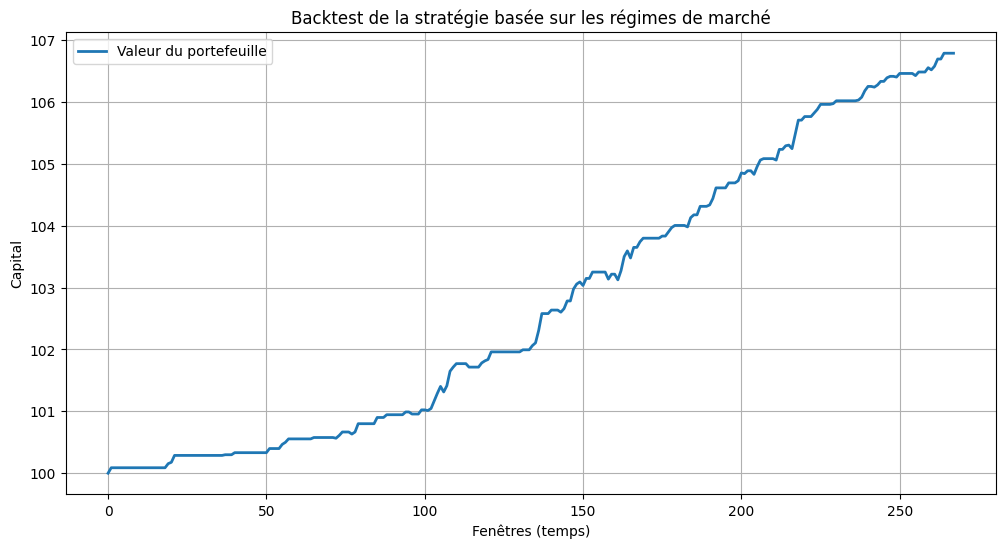

In [155]:
def backtest_strategy(processed_data, labels, close_prices, H2, initial_capital=100):
    """
    Backtest une stratégie basée sur les régimes de marché détectés.

    :param processed_data: Log-rendements moyens (output de preprocess_data)
    :param labels: Clusters (régimes) associés à chaque fenêtre
    :param close_prices: Prix originaux (données 'Close')
    :param H2: Pas entre fenêtres (doit matcher avec preprocess)
    :param initial_capital: Capital de départ
    :return: Valeur cumulée du portefeuille dans le temps
    """
    # Définir les signaux de position
    position_map = {0: -1, 1: 0, 2: 1}  # achat / hold / short
    positions = np.array([position_map[label] for label in labels])

    # Calcul des rendements alignés avec les fenêtres glissantes
    returns = []
    for i in range(0, len(close_prices) - H2, H2):
        ret = (close_prices[i + H2] - close_prices[i]) / close_prices[i]
        returns.append(ret)
    returns = np.array(returns[:len(positions)])  # tronquer si besoin

    # Calcul de la valeur du portefeuille dans le temps
    portfolio = [initial_capital]
    for i in range(len(returns)):
        new_value = portfolio[-1] * (1 + positions[i] * returns[i])
        portfolio.append(new_value)

    return np.array(portfolio), positions, returns

# Lancer le backtest
portfolio_values, positions, returns = backtest_strategy(processed_data, labels, close_prices, H2)

# Afficher la performance
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Valeur du portefeuille", linewidth=2)
plt.xlabel("Fenêtres (temps)")
plt.ylabel("Capital")
plt.title("Backtest de la stratégie basée sur les régimes de marché")
plt.legend()
plt.grid(True)
plt.show()

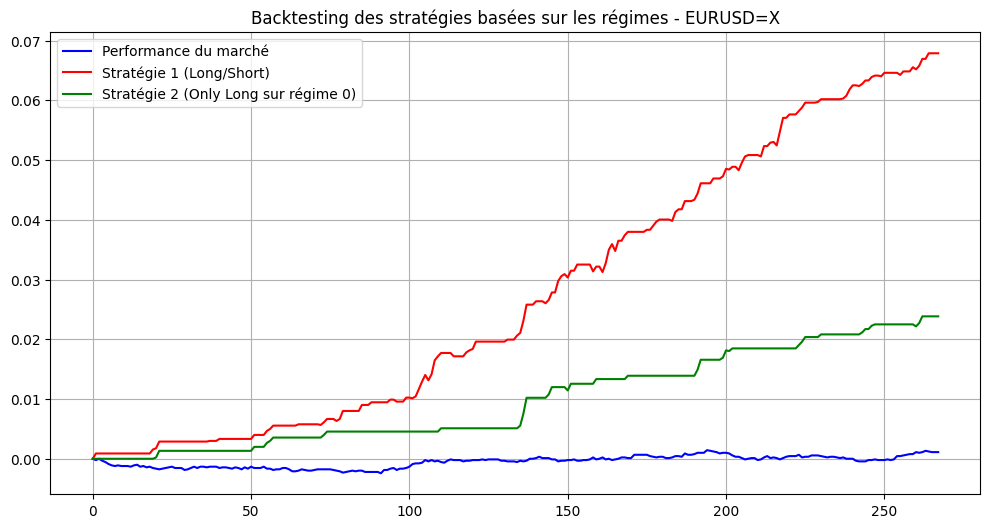

In [157]:
def backtest_strategy_2(processed_data, labels, close_prices, H2, initial_capital=100):
    """
    Stratégie 2 : long uniquement sur régime 0, sinon cash.
    """
    capital = [initial_capital]
    in_position = False
    entry_price = 0

    for i in range(len(labels)):
        price_index = i * H2
        if price_index + H2 >= len(close_prices):
            break

        current_price = close_prices[price_index]
        next_price = close_prices[price_index + H2]

        if labels[i] == 2:
            if not in_position:
                in_position = True
                entry_price = current_price
                capital.append(capital[-1])
            else:
                # garder la position
                pct_change = (next_price - current_price) / current_price
                capital.append(capital[-1] * (1 + pct_change))
        else:
            if in_position:
                in_position = False
            capital.append(capital[-1])  # on reste en cash

    return np.array(capital)

# Stratégie 1 (celle existante)
portfolio_1, _, _ = backtest_strategy(processed_data, labels, close_prices, H2)

# Stratégie 2
portfolio_2 = backtest_strategy_2(processed_data, labels, close_prices, H2)

# Benchmark (marché)
returns_market = np.diff(close_prices) / close_prices[:-1]
cumulative_market = np.cumsum(returns_market[:len(portfolio_1)-1])
cumulative_market = np.insert(cumulative_market, 0, 0)  # Pour l'aligner

# Plot
plt.figure(figsize=(12, 6))
plt.plot(cumulative_market, color='blue', label="Performance du marché")
plt.plot(np.array(portfolio_1)/portfolio_1[0]-1, color='red', label="Stratégie 1 (Long/Short)")
plt.plot(np.array(portfolio_2)/portfolio_2[0]-1, color='green', label="Stratégie 2 (Only Long sur régime 0)")
plt.title("Backtesting des stratégies basées sur les régimes - EURUSD=X")
plt.legend()
plt.grid(True)
plt.show()